In [12]:
# pip install kaggle

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
from transformers import pipeline
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
from tqdm import tqdm
import re
from datasets import Dataset
from transformers import AutoModelForSequenceClassification
import torch
import numpy as np
from typing import Dict
from transformers import AutoModel
from torch.nn import BCEWithLogitsLoss
from typing import List
from transformers import TrainingArguments, Trainer
from collections import defaultdict

from transformers import __version__ as transformers_version

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-04-10 10:11:09.359041: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPT

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = "distilbert-base-cased"

cpu


***Скачивание и обработка данных***

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "arxivData.json"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "neelshah18/arxivdataset",
  file_path,
)

print(df.head)
print(df.columns)

/tmp/ipykernel_3402/637306215.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


<bound method NDFrame.head of                                                   author  ...  year
0      [{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...  ...  2018
1      [{'name': 'Ji Young Lee'}, {'name': 'Franck De...  ...  2016
2      [{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...  ...  2016
3      [{'name': 'Sebastian Ruder'}, {'name': 'Joachi...  ...  2017
4      [{'name': 'Iulian V. Serban'}, {'name': 'Chinn...  ...  2017
...                                                  ...  ...   ...
40995  [{'name': 'Vitaly Feldman'}, {'name': 'Pravesh...  ...  2014
40996  [{'name': 'Orly Avner'}, {'name': 'Shie Mannor'}]  ...  2014
40997  [{'name': 'Ran Zhao'}, {'name': 'Deanna Needel...  ...  2014
40998  [{'name': 'Zongyan Huang'}, {'name': 'Matthew ...  ...  2014
40999  [{'name': 'Imen Trabelsi'}, {'name': 'Dorra Be...  ...  2014

[41000 rows x 9 columns]>
Index(['author', 'day', 'id', 'link', 'month', 'summary', 'tag', 'title',
       'year'],
      dtype='object')


In [4]:
arxiv_topics_df = pd.read_csv('arxiv_topics.csv')
print(len(arxiv_topics_df))
arxiv_topics_df.head(5)

155


tag                                            topic          category
0  cs.AI                          Artificial Intelligence  Computer Science
1  cs.AR                            Hardware Architecture  Computer Science
2  cs.CC                         Computational Complexity  Computer Science
3  cs.CE  Computational Engineering, Finance, and Science  Computer Science
4  cs.CG                           Computational Geometry  Computer Science

In [5]:
print(arxiv_topics_df['tag'].unique())

['cs.AI' 'cs.AR' 'cs.CC' 'cs.CE' 'cs.CG' 'cs.CL' 'cs.CR' 'cs.CV' 'cs.CY'
 'cs.DB' 'cs.DC' 'cs.DL' 'cs.DM' 'cs.DS' 'cs.ET' 'cs.FL' 'cs.GL' 'cs.GR'
 'cs.GT' 'cs.HC' 'cs.IR' 'cs.IT' 'cs.LG' 'cs.LO' 'cs.MA' 'cs.MM' 'cs.MS'
 'cs.NA' 'cs.NE' 'cs.NI' 'cs.OH' 'cs.OS' 'cs.PF' 'cs.PL' 'cs.RO' 'cs.SC'
 'cs.SD' 'cs.SE' 'cs.SI' 'cs.SY' 'econ.EM' 'econ.GN' 'econ.TH' 'eess.AS'
 'eess.IV' 'eess.SP' 'eess.SY' 'math.AC' 'math.AG' 'math.AP' 'math.AT'
 'math.CA' 'math.CO' 'math.CT' 'math.CV' 'math.DG' 'math.DS' 'math.FA'
 'math.GM' 'math.GN' 'math.GR' 'math.GT' 'math.HO' 'math.IT' 'math.KT'
 'math.LO' 'math.MG' 'math.MP' 'math.NA' 'math.NT' 'math.OA' 'math.OC'
 'math.PR' 'math.QA' 'math.RA' 'math.RT' 'math.SG' 'math.SP' 'math.ST'
 'astro-ph.CO' 'astro-ph.EP' 'astro-ph.GA' 'astro-ph.HE' 'astro-ph.IM'
 'astro-ph.SR' 'cond-mat.dis-nn' 'cond-mat.mes-hall' 'cond-mat.mtrl-sci'
 'cond-mat.other' 'cond-mat.quant-gas' 'cond-mat.soft'
 'cond-mat.stat-mech' 'cond-mat.str-el' 'cond-mat.supr-con' 'gr-qc'
 'hep-ex' 'he

In [6]:
category_to_ind = {
    'Computer Science': 0,
    'Economics': 1,
    'Electrical Engineering and Systems Science': 2,
    'Mathematics': 3,
    'Physics': 4,
    'Quantitative Biology': 5,
    'Quantitative Finance': 6,
    'Statistics': 7
}

ind_to_category = {}
for k, v in category_to_ind.items():  
    ind_to_category[v] = k

term_to_category = {}
for i in range(len(arxiv_topics_df)):
    term_to_category[arxiv_topics_df['tag'][i]] = arxiv_topics_df['category'][i]


print(arxiv_topics_df['category'].unique())

['Computer Science' 'Economics'
 'Electrical Engineering and Systems Science' 'Mathematics' 'Physics'
 'Quantitative Biology' 'Quantitative Finance' 'Statistics']


In [9]:
import csv

with open('ind_to_category.csv', mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['key', 'value'])  # header
    for key, value in ind_to_category.items():
        writer.writerow([key, value])

In [10]:
ind_to_category_copy = {}
with open('ind_to_category.csv', mode='r', newline='') as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    for key, value in reader:
        ind_to_category_copy[key] = value

print(ind_to_category_copy)

{'0': 'Computer Science', '1': 'Economics', '2': 'Electrical Engineering and Systems Science', '3': 'Mathematics', '4': 'Physics', '5': 'Quantitative Biology', '6': 'Quantitative Finance', '7': 'Statistics'}


In [7]:
import ast
import scipy

arxiv_data = []
for i in range(len(df)):
    cur_elem = {} 
    cur_elem['inp'] = df['title'][i] + '@' + df['summary'][i]
    probs = [0] * len(category_to_ind)
    parsed_tags = ast.literal_eval(df['tag'][i])
    total_tags = len(parsed_tags)
    for j in range(len(parsed_tags)):
        term = parsed_tags[j]['term']
        if term not in term_to_category:
            continue
        category = term_to_category[term]
        ind = category_to_ind[category]
        probs[ind] += 1
    probs = scipy.special.softmax(probs)
    cur_elem['probs'] = probs
    arxiv_data.append(cur_elem)
    
    
print(arxiv_data[0])

{'inp': 'Dual Recurrent Attention Units for Visual Question Answering@We propose an architecture for VQA which utilizes recurrent layers to\ngenerate visual and textual attention. The memory characteristic of the\nproposed recurrent attention units offers a rich joint embedding of visual and\ntextual features and enables the model to reason relations between several\nparts of the image and question. Our single model outperforms the first place\nwinner on the VQA 1.0 dataset, performs within margin to the current\nstate-of-the-art ensemble model. We also experiment with replacing attention\nmechanisms in other state-of-the-art models with our implementation and show\nincreased accuracy. In both cases, our recurrent attention mechanism improves\nperformance in tasks requiring sequential or relational reasoning on the VQA\ndataset.', 'probs': array([0.86230617, 0.01579369, 0.01579369, 0.01579369, 0.01579369,
       0.01579369, 0.01579369, 0.0429317 ])}


In [8]:
import ast
parsed_list = ast.literal_eval(df['tag'][0])
print(parsed_list[0])

{'term': 'cs.AI', 'scheme': 'http://arxiv.org/schemas/atom', 'label': None}


In [9]:
print(len(arxiv_data))

41000


In [10]:
from transformers import DistilBertTokenizer, DistilBertModel

# Load pretrained tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')


In [11]:
MAX_LENGTH = 512
tokenized_sentence = tokenizer(arxiv_data[0]['inp'], padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
print(tokenized_sentence['input_ids'].shape)
print(tokenized_sentence['attention_mask'].shape)

# max_inp_size = 0
# avg_inp_size = 0
# for i in range(len(arxiv_data)):
#     max_inp_size = max(max_inp_size, len(arxiv_data[i]['inp']))
#     avg_inp_size += len(arxiv_data[i]['inp'])

# avg_inp_size /= len(arxiv_data)

# print(avg_inp_size)
# print(max_inp_size)

torch.Size([1, 512])
torch.Size([1, 512])


In [12]:
from torch.utils.data import DataLoader, Dataset

class ArxivDataset(Dataset):
    def __init__(self, split="train"):
        if (split == "train"):
            self.data = arxiv_data[:39000]
        else:
            self.data = arxiv_data[-2000:]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        #обрабатываем элемент
        cur_elem = self.data[idx]
        
        # Tokenize input and label
        encoding = tokenizer(cur_elem["inp"], padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        labels = torch.FloatTensor(cur_elem["probs"])
        
        # input_ids = encoding["input_ids"].squeeze(0)  # Remove batch dim
        # attention_mask = encoding["attention_mask"].squeeze(0)
        input_ids = encoding["input_ids"].squeeze(0)  # Remove batch dim
        attention_mask = encoding["attention_mask"].squeeze(0)
        
        
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

BATCH_SIZE = 10

train_dataset = ArxivDataset("train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = ArxivDataset("test")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

***Разберемся с моделью***

In [13]:
model = DistilBertModel.from_pretrained('distilbert-base-cased')
model.eval()


# output = model(train_dataset[0]["input_ids"], train_dataset[0]["attention_mask"])
# config = model.config

batch = next(iter(train_dataloader))

print(batch['input_ids'].shape)
print(batch['attention_mask'].shape)
print(batch['labels'].shape)
print(model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask']).last_hidden_state.shape)

torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 8])
torch.Size([10, 512, 768])


In [14]:
from torch import nn

class ClassificationModel(nn.Module):
    def __init__(self, base_model):
        super(ClassificationModel, self).__init__()
        self.base_model = base_model
        # self.linear = nn.Linear(768, 8)
        # self.softmax = nn.Softmax(dim=1)
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),   # Optional intermediate layer
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 8),      # Final layer to 8 classes
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input_ids, attention_mask):
        hidden_states = self.base_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # shape: [batch, max_len, hidden_size]
        cls_output = hidden_states[:, 0, :]        # Use [CLS] token
        probs = self.classifier(cls_output)        # (batch_size, 8), now probabilities
        return probs


In [15]:
class_model = ClassificationModel(model)

# class_model = torch.load("model_weights.pth")
class_model.load_state_dict(torch.load("model_weights.pth", weights_only=True))

class_model.to(device)

for param in class_model.base_model.parameters():
    param.requires_grad = False

# print(class_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask']).shape)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Trainable parameters:", count_parameters(class_model))

Trainable parameters: 198920


***Training***

In [33]:
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import torch

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    train_dataloader,
    val_dataloader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=3,
    val_every=100,
    draw_every=50,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
):

    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype

    losses = {'train': [], 'val': [], 'accuracy_val': [], 'lr': []}
    # lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)
    start_time = time.monotonic()
    
    # [1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
    idx = 0

    for epoch in range(1, epochs + 1):
        model.train()

        for batch_idx, batch in enumerate(train_dataloader):
            if idx % 10 == 0:
                print(idx)
            idx += 1

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = (batch["labels"]).to(device)

            # attention_mask = attention_mask.to(dtype=dtype)

            optimizer.zero_grad()

            model_probs = model(input_ids, attention_mask)
            
            # print(torch.sum(model_probs))
            # print(torch.sum(labels))

            model_loss = criterion(
                model_probs,
                labels
            )
            # print(model_loss.item())
            
            model_loss.backward()
            optimizer.step()
            scheduler.step()
            
            current_lr = optimizer.param_groups[0]['lr']
            losses['lr'].append(current_lr)
            losses['train'].append(model_loss.item())

            # validation
            if idx % val_every == 0:
                model.eval()


                with torch.no_grad():
                    for idx_val, batch in enumerate(val_dataloader):
                        if idx_val == 10:
                            break

                        input_ids = batch["input_ids"].to(device)
                        attention_mask = batch["attention_mask"].to(device)
                        labels = (batch["labels"]).to(device)

                        # attention_mask = attention_mask.to(dtype=dtype)

                        model_probs_val = model(input_ids, attention_mask)

                        val_loss = criterion(
                            model_probs_val,
                            labels
                        )
                        
                        losses['val'].append(val_loss.item())
                        

                
                torch.cuda.empty_cache()
                model.train()

            # plotting
            if idx % draw_every == 0:
                clear_output(True)
                plt.clf()
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.plot(losses['train'], label='train_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Training Losses')
                plt.legend()
                plt.grid(True)

                plt.subplot(1, 2, 2)
                plt.plot(losses['val'], label='val_loss')
                plt.xlabel('Iter')
                plt.ylabel('Loss')
                plt.title('Validation Losses')
                plt.legend()
                plt.grid(True)

                plt.tight_layout()
                plt.show()

    return losses

In [34]:
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import LinearLR
import torch.optim as optim


num_epochs = 3

total_steps = num_epochs * len(train_dataloader)  # Total training steps

optimizer = optim.Adam(model.parameters(), lr=1e-3)

scheduler = CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=0)

print(total_steps)

11700


<Figure size 640x480 with 0 Axes>

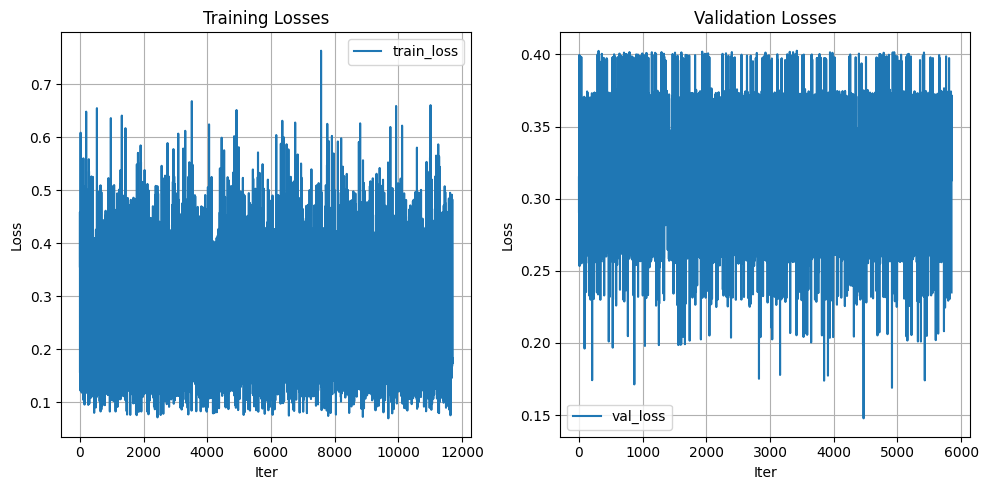

In [35]:
import numpy as np

losses = learning_loop(
    class_model,
    optimizer,
    train_dataloader,
    val_dataloader,
    # nn.CrossEntropyLoss(),
    nn.KLDivLoss(reduction="batchmean"),
    scheduler=scheduler,
    min_lr=None,
    epochs=num_epochs,
    val_every=20,
    draw_every=50,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
)


In [37]:
torch.save(class_model.state_dict(), "model_weights.pth")
torch.save(class_model.state_dict(), "pytorch_model.bin")

In [38]:
def inference(
    title,
    abstract,
    threshold=0.50
):
    cur_elem = title + '@' + abstract

    # Tokenize input and label
    encoding = tokenizer(cur_elem, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    # input_ids.to(device)
    attention_mask.to(device)
    class_model.to(device)
    
    res_probs = torch.exp(class_model(input_ids, attention_mask))
    
    print(res_probs)
    
    probs = res_probs.squeeze(0)  # (8,)
    
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)

    total = 0.0
    selected_indices = []
    
    for prob, idx in zip(sorted_probs, sorted_indices):
        total += prob.item()
        selected_indices.append(idx.item())
        if total >= threshold:
            break

    ans_themes = [ind_to_category[elem] for elem in selected_indices]
    return ans_themes

In [39]:
inference('Dual Recurrent Attention Units for Visual Question Answering', 'We propose an architecture for VQA which utilizes recurrent layers to\ngenerate visual and textual attention. The memory characteristic of the\nproposed recurrent attention units offers a rich joint embedding of visual and\ntextual features and enables the model to reason relations between several\nparts of the image and question. Our single model outperforms the first place\nwinner on the VQA 1.0 dataset, performs within margin to the current\nstate-of-the-art ensemble model. We also experiment with replacing attention\nmechanisms in other state-of-the-art models with our implementation and show\nincreased accuracy. In both cases, our recurrent attention mechanism improves\nperformance in tasks requiring sequential or relational reasoning on the VQA\ndataset.')

tensor([[0.1338, 0.1863, 0.1153, 0.1085, 0.1025, 0.1116, 0.1232, 0.1188]],
       device='cuda:0', grad_fn=<ExpBackward0>)


['Economics', 'Computer Science', 'Quantitative Finance', 'Statistics']

In [ ]:
print(device)